In [ ]:
pip install pandas numpy scikit-learn joblib matplotlib seaborn


In [ ]:
# Training a Random Forest Classifier for Presence Detection

This notebook trains a Random Forest Classifier to predict presence (`1`) or absence (`0`) using ultrasonic sensor data from two folders collected on different days. The steps include:

1. Load data from multiple directories.
2. Extract statistical features from 25,000-point signals.
3. Train and evaluate the model.
4. Visualize feature importance and confusion matrix.
5. Save the model for use in the main application.

                 

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Enable inline plotting for Jupyter
%matplotlib inline

print("Libraries imported successfully!")


Libraries imported successfully!


In [ ]:
labels = ["Person", "MovingPerson", "SittingPerson", "StandingPerson", "Object", "Doubt"]

# Root folder that contains multiple dataset folders
data_root = r"D:/Individual Project/MyProject/IntelliLight DCL Tool/DataCollection"

data = []
target = []

print(f"Looking for datasets in: {data_root}")

for dataset_folder in os.listdir(data_root):
    dataset_path = os.path.join(data_root, dataset_folder)

    if not os.path.isdir(dataset_path):
        continue

    print(f"\n Processing dataset: {dataset_folder}")

    for label in labels:
        label_path = os.path.join(dataset_path, label)

        if not os.path.isdir(label_path):
            print(f" Label '{label}' not found in this dataset, skipping.")
            continue

        print(f" Label: {label}")

        for file in os.listdir(label_path):
            if file.lower().endswith(".csv"):
                file_path = os.path.join(label_path, file)

                try:
                    df = pd.read_csv(file_path)

                    if 'raw_adc' in df.columns and len(df) == 25000:
                        if np.isnan(df['raw_adc']).any() or np.isinf(df['raw_adc']).any():
                            print(f"   Skipping (NaN/Inf): {file}")
                            continue

                        data.append(df['raw_adc'].values)
                        target.append(label)

                    else:
                        print(f" Skipping (Invalid size/format): {file}")

                except Exception as e:
                    print(f" Error reading {file}: {e}")


print("\n Data Loading Complete")
print(f"Total Samples Loaded: {len(data)}")


In [16]:
from collections import Counter

# After loading data
label_counts = Counter(target)

print("\n=== Label Counts ===")
for label in labels:
    print(f"{label}: {label_counts.get(label, 0)}")
print("====================")



=== Label Counts ===
Person: 125
MovingPerson: 4804
SittingPerson: 55034
StandingPerson: 16993
Object: 84691
Doubt: 2617


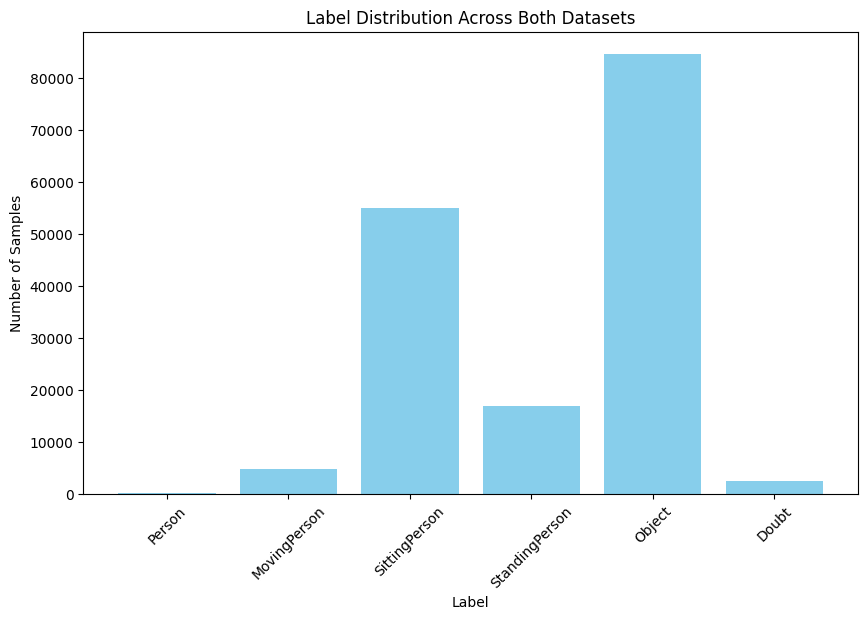

In [18]:
# Plot label distribution
label_counts = Counter(target)
plt.figure(figsize=(10, 6))
plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.title('Label Distribution Across Both Datasets')
plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

In [20]:
# Feature extraction function
def extract_features(signal):
    """Extract statistical features from a 25,000-point raw_adc signal."""
    return [
        np.mean(signal),            # Mean
        np.std(signal),             # Standard deviation
        np.max(signal),             # Maximum value
        np.min(signal),             # Minimum value
        np.ptp(signal),             # Peak-to-peak
        np.var(signal),             # Variance
        np.median(signal),          # Median
        np.percentile(signal, 25),  # 25th percentile
        np.percentile(signal, 75),  # 75th percentile
    ]

# Extract features and create binary labels
X = np.array([extract_features(signal) for signal in data])
y = np.array(target)
y_binary = np.where(np.isin(y, ["Person", "MovingPerson", "SittingPerson", "StandingPerson"]), 1, 0)

print(f"Feature matrix shape: {X.shape}")
print(f"Binary labels shape: {y_binary.shape}")

Feature matrix shape: (164264, 9)
Binary labels shape: (164264,)


In [21]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Train Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
model.fit(X_train, y_train)

print("Model training completed!")

Model training completed!


In [26]:
# Evaluate model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Absence", "Presence"]))

Test Accuracy: 0.91
Classification Report:
              precision    recall  f1-score   support

     Absence       0.92      0.90      0.91     17568
    Presence       0.89      0.91      0.90     15285

    accuracy                           0.91     32853
   macro avg       0.91      0.91      0.91     32853
weighted avg       0.91      0.91      0.91     32853



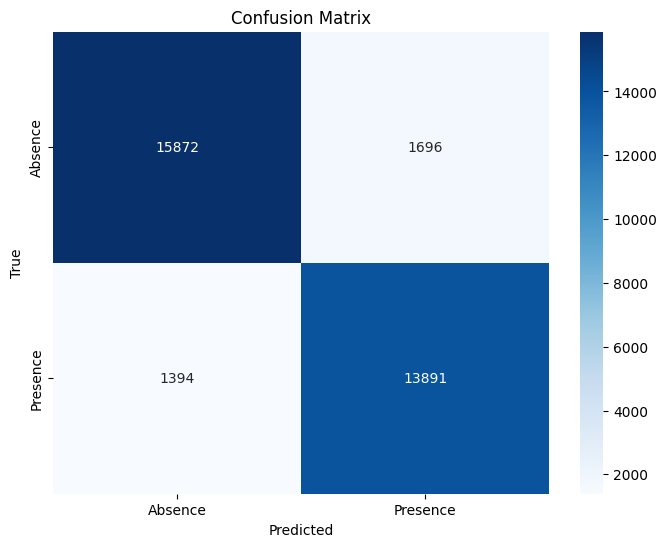

In [28]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Absence", "Presence"], yticklabels=["Absence", "Presence"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

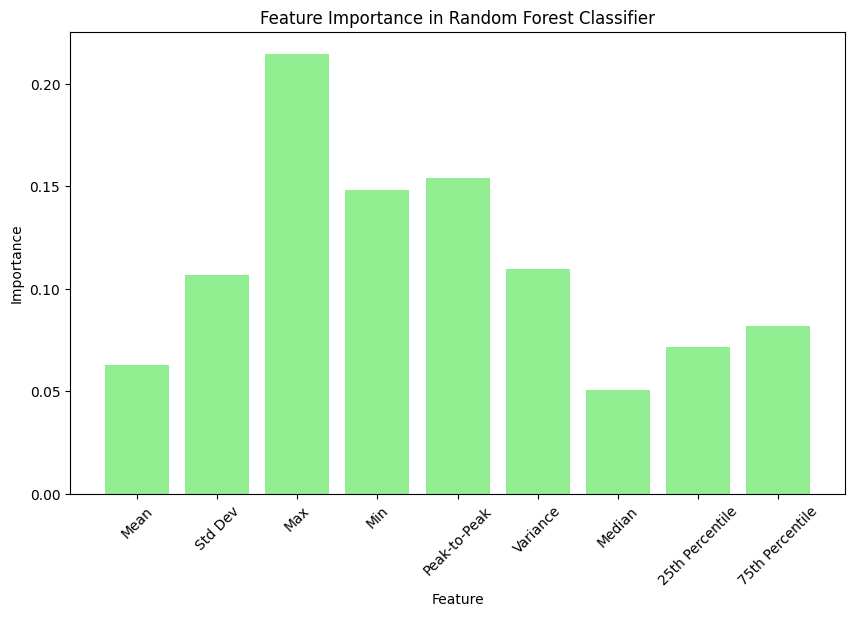

In [30]:
# Plot feature importance
feature_names = ["Mean", "Std Dev", "Max", "Min", "Peak-to-Peak", "Variance", "Median", "25th Percentile", "75th Percentile"]
importances = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(feature_names, importances, color='lightgreen')
plt.title('Feature Importance in Random Forest Classifier')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

In [32]:
# Save model
model_filename = "presence_detection_model_31102025.pkl"
joblib.dump(model, model_filename)
print(f"Model saved to {model_filename}")

Model saved to presence_detection_model_31102025.pkl
